## Dependancies and Imports

In [1]:
!pip install -r ../requirements.txt
# !pip install googletrans==3.1.0a0
# !pip install --upgrade transformers

In [2]:
import datetime
import pandas as pd
from sklearn import metrics
import time
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

pd.set_option("display.max_columns", None)

e:\Programming\Solutions\UT\.torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load Data and Data Preprocessing

In [4]:
# df = pd.read_csv("./drive/MyDrive/CSC413_data/leetcode_dataset - lc.csv")
df = pd.read_csv("../data_preprocessing/data_raw/leetcode_dataset - lc.csv")
## drop sql schema
df.drop(df[df.description.str.contains("SQL Schema")].index, inplace=True)
## drop nan in related_topics
df.dropna(subset=["related_topics"], inplace=True)
## lower case all description
df["description"] = df["description"].str.lower()
## split related_topics
df["related_topics"] = df["related_topics"].str.split(",")
df.sample(10)

,id,title,description,is_premium,difficulty,solution_link,acceptance_rate,frequency,url,discuss_count,accepted,submissions,companies,related_topics,likes,dislikes,rating,asked_by_faang,similar_questions
1191,1192,Critical Connections in a Network,there are `n` servers numbered from `0` to `n-...,0,Hard,/articles/critical-connections-in-a-network,50.3,76.3,https://leetcode.com/problems/critical-connect...,436,101.6K,202.1K,"Amazon,Adobe",[Depth-first Search],2165,110,95,1,NaN
733,734,Sentence Similarity,we can represent a sentence as an array of wor...,1,Easy,/articles/sentence-similarity,42.4,3.0,https://leetcode.com/problems/sentence-similarity,200,40.7K,95.9K,Facebook,[Hash Table],214,356,38,1,"[Number of Provinces, /problems/number-of-prov..."
190,191,Number of 1 Bits,write a function that takes an unsigned intege...,0,Easy,/articles/number-1-bits,54.2,26.0,https://leetcode.com/problems/number-of-1-bits,999,482.6K,889.8K,"Box,Cisco,Microsoft,Qualcomm",[Bit Manipulation],1430,629,69,0,"[Reverse Bits, /problems/reverse-bits/, Easy],..."
1557,1558,Minimum Numbers of Function Calls to Make Targ...,your task is to form an integer array `nums` f...,0,Medium,NaN,63.4,0.0,https://leetcode.com/problems/minimum-numbers-...,136,10.9K,17.3K,Amazon,[Greedy],247,15,94,1,NaN
352,353,Design Snake Game,design a snake game that is played on a device...,1,Medium,/articles/design-snake-game,36.2,42.9,https://leetcode.com/problems/design-snake-game,271,45.5K,125.7K,"Amazon,Microsoft","[Design, Queue]",531,216,71,1,NaN
1629,1630,Arithmetic Subarrays,a sequence of numbers is called arithmetic if ...,0,Medium,NaN,77.7,0.0,https://leetcode.com/problems/arithmetic-subar...,203,15.7K,20.2K,Google,[Sort],202,28,88,1,"[Arithmetic Slices, /problems/arithmetic-slice..."
658,659,Split Array into Consecutive Subsequences,given an integer array `nums` that is sorted i...,0,Medium,/articles/split-array-into-consecutive-subsequ...,44.5,22.6,https://leetcode.com/problems/split-array-into...,312,57K,128.1K,Uber,"[Heap, Greedy]",1557,478,77,0,"[Top K Frequent Elements, /problems/top-k-freq..."
687,688,Knight Probability in Chessboard,"on an `n`x`n` chessboard, a knight starts at t...",0,Medium,/articles/knight-probability-in-chessboard,50.3,28.1,https://leetcode.com/problems/knight-probabili...,432,58.5K,116.4K,"Goldman Sachs,Amazon",[Dynamic Programming],1240,231,84,1,"[Out of Boundary Paths, /problems/out-of-bound..."
447,448,Find All Numbers Disappeared in an Array,given an array `nums` of `n` integers where `n...,0,Easy,/articles/find-all-numbers-disappeared-in-an-a...,56.1,39.4,https://leetcode.com/problems/find-all-numbers...,999,360.5K,642.1K,Amazon,[Array],4041,291,93,1,"[First Missing Positive, /problems/first-missi..."
442,443,String Compression,"given an array of characters `chars`, compress...",0,Medium,/articles/string-compression,44.1,80.1,https://leetcode.com/problems/string-compression,955,163.4K,370.4K,"Goldman Sachs,Yandex,Microsoft,Apple,Citrix,Fa...",[String],1251,3168,28,1,"[Count and Say, /problems/count-and-say/, Medi..."


In [5]:
inputs = df["description"].values
labels_ori = df['related_topics'].values
print(inputs[0])
print(labels_ori[0])
print(len(inputs))

given an array of integers `nums` and an integer `target`, return indices of the two numbers such that they add up to `target`.

you may assume that each input would have exactly one solution, and you may not use the same element twice.

you can return the answer in any order.


example 1:
input: nums = [2,7,11,15], target = 9
output: [0,1]
output: because nums[0] + nums[1] == 9, we return [0, 1].

example 2:
input: nums = [3,2,4], target = 6
output: [1,2]

example 3:
input: nums = [3,3], target = 6
output: [0,1]

constraints:
`2 <= nums.length <= 103`
`-109 <= nums[i] <= 109`
`-109 <= target <= 109`
only one valid answer exists.
['Array', 'Hash Table']
1571


In [6]:
## label tags to binary
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels_ori)
print(labels[0])
print(mlb.inverse_transform(labels[0].reshape(1,-1)))
print(mlb.classes_)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
[('Array', 'Hash Table')]
['Array' 'Backtracking' 'Binary Indexed Tree' 'Binary Search'
 'Binary Search Tree' 'Bit Manipulation' 'Brainteaser'
 'Breadth-first Search' 'Depth-first Search' 'Dequeue' 'Design'
 'Divide and Conquer' 'Dynamic Programming' 'Geometry' 'Graph' 'Greedy'
 'Hash Table' 'Heap' 'Line Sweep' 'Linked List' 'Math'
 'Meet in the Middle' 'Memoization' 'Minimax' 'OOP' 'Ordered Map' 'Queue'
 'Random' 'Recursion' 'Rejection Sampling' 'Reservoir Sampling'
 'Rolling Hash' 'Segment Tree' 'Sliding Window' 'Sort' 'Stack' 'String'
 'Suffix Array' 'Topological Sort' 'Tree' 'Trie' 'Two Pointers'
 'Union Find']


(array([ 3., 15., 27., 44., 51., 66., 74., 62., 79., 85., 67., 63., 87.,
        67., 73., 58., 71., 48., 52., 43., 44., 42., 37., 42., 35., 19.,
        25., 18., 22., 13., 16., 18.,  8., 10.,  7.,  6.,  8.,  8.,  4.,
        10.,  2.,  6.,  3.,  1.,  4.,  1.,  0.,  1.,  4.,  1.,  1.,  1.,
         1.,  2.,  1.,  2.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  1.,
         1.,  2.,  0.,  0.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 34.  ,  42.91,  51.82,  60.73,  69.64,  78.55,  87.46,  96.37,
        105.28, 114.19, 123.1 , 132.01, 140.92, 149.83, 158.74, 167.65,
        176.56, 185.47, 194.38, 203.29, 212.2 , 221.11, 230.02, 238.93,
        247.84, 256.75, 265.66, 274.57, 283.48, 292.39, 301.3 , 310.21,
        319.12, 328.03, 336.94, 345.85, 354.76, 363.67, 372.58, 381.49,
        390.4 , 399.31, 408.22, 417.13, 426.04, 434.95, 443.86, 452.77,
  

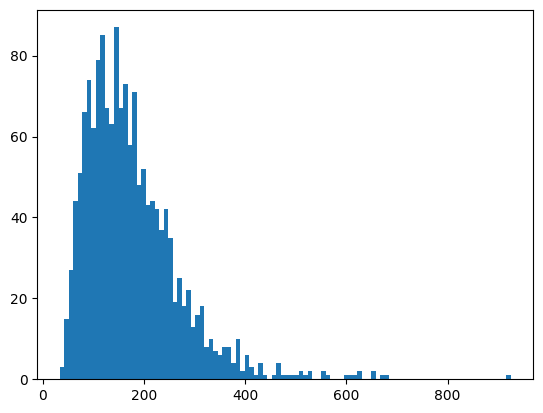

In [7]:
## check the distribution of length of inputs
inputs_len = [len(i.split()) for i in inputs]
plt.hist(inputs_len, bins=100)

In [35]:
# hyperparameters
MAX_LEN = 512
num_labels = len(mlb.classes_)
batch_size = 8
LEARNING_RATE = 2e-5

In [36]:
## word embedding using glove
import torch.nn as nn
from torchtext.vocab import GloVe

# load the pre-trained GloVe model with 100-dimensional embeddings
glove = GloVe(name='6B', dim=300)

# set the maximum length of the input strings
max_length = 100

# define the embedding layer
embedding_layer = nn.Embedding(len(glove.itos), 300)
embedding_layer.weight.data.copy_(glove.vectors)

# define a function to convert input strings into numerical vectors
def glove_tokenizer(text):

    # split the input string into individual words
    words = text.split()
    
    # initialize a temporary list to hold the indices of all words in the input string
    indices = []
    
    # loop over each word in the input string
    for word in words:
        # if the word is not in the pre-trained GloVe model, skip it
        if word not in glove.stoi:
            continue
            
        # look up the index of the word in the pre-trained GloVe model
        index = glove.stoi[word]
        
        # add the index to the temporary list
        indices.append(index)
    
    # pad the list of indices with zeros to make it the same length as the maximum length
    indices += [0] * (max_length - len(indices))
    
    # convert the list of indices into a PyTorch tensor
    indices_tensor = torch.tensor(indices)
    
    # convert the tensor of indices into a tensor of numerical vectors using the embedding layer
    vector_tensor = embedding_layer(indices_tensor).mean(dim=0)

    # stack the list of numerical vectors into a PyTorch tensor of shape (num_inputs, 300)
    return vector_tensor

print(glove_tokenizer(inputs[0]))


tensor([-1.1476e-01,  1.8802e-01, -3.7333e-02, -2.0750e-01, -1.4193e-01,
         9.4439e-02, -1.0180e-01,  1.2715e-01, -3.6650e-02, -1.5465e+00,
        -1.4673e-02,  1.1268e-01, -7.7418e-02,  5.1625e-02,  1.7759e-02,
         1.1689e-01, -1.6060e-01, -7.7406e-02, -1.1853e-01, -1.1082e-01,
        -1.5944e-01,  7.2837e-02,  2.2259e-01,  6.7503e-02, -6.9378e-02,
        -7.8875e-02,  4.6822e-02, -7.5216e-03, -1.6564e-01, -1.0504e-02,
         3.8817e-02,  2.3384e-01, -2.5660e-01,  9.9788e-02, -7.0982e-01,
        -2.7969e-02,  1.5173e-01, -4.1461e-02, -1.0999e-01,  1.2725e-01,
         3.9070e-02, -1.0160e-01, -1.5435e-01,  2.5016e-01,  8.5946e-02,
         7.8045e-02,  6.6252e-02,  1.0102e-01, -1.8427e-01,  6.0424e-02,
         1.6211e-01, -7.6610e-02,  1.5551e-02, -5.4577e-02, -8.9845e-02,
         2.0722e-01, -5.5075e-02,  1.9141e-01,  1.3444e-01,  5.4440e-02,
         7.9659e-02,  4.9190e-02,  1.8300e-01, -6.5080e-02, -4.5392e-02,
        -3.4303e-01,  1.0437e-01,  5.0513e-02,  7.2

In [37]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base", do_lower_case=True)

### Data Augmentation

In [38]:
# data augmentation
from googletrans import Translator
translator = Translator()
def transform(text):
    # randomly select a language to translate to
    lang = np.random.choice(['fr', 'zh-cn', 'es', 'de', 'ru', 'ja', 'ko'])
    translated = translator.translate(text, dest=lang)
    # then translate back to english
    translated = translator.translate(translated.text, dest='en')
    return translated.text

In [39]:
class BERTDataset(Dataset):
    def __init__(self, tokenizer, inputs, tags, transform=None, max_len=512):
        self.labels = tags
        self.data = inputs
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = self.data[index]
        if self.transform:
            text = self.transform(text)
        labels = self.labels[index]
        labels = torch.tensor(labels, dtype=torch.float)
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        input_ids = inputs['input_ids']
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        attention_mask = inputs['attention_mask']
        attention_mask = torch.tensor(attention_mask, dtype=torch.long)
        token_type_ids = inputs['token_type_ids']
        token_type_ids = torch.tensor(token_type_ids, dtype=torch.long)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'labels': labels
        }

In [40]:
def data_split(inputs, labels, test_size=0.2, random_state=42, tokenizer=None, MAX_LEN=512, transform=None, batch_size=32):
    inputs_train, inputs_test, labels_train, labels_test = train_test_split(inputs, labels, test_size=0.2, random_state=42, shuffle=True)
    inputs_train, inputs_val, labels_train, labels_val = train_test_split(inputs_train, labels_train, test_size=0.2, random_state=42, shuffle=True)
    train = BERTDataset(tokenizer, inputs_train, labels_train, transform, MAX_LEN)
    val = BERTDataset(tokenizer, inputs_val, labels_val, transform, MAX_LEN)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size)
    return train_loader, val_loader, inputs_test, labels_test

In [41]:
train_loader, val_loader, inputs_test, labels_test = data_split(
    inputs, 
    labels, 
    tokenizer=tokenizer, 
    MAX_LEN=MAX_LEN, 
    transform=transform, 
    batch_size=batch_size
)

### Model && Utils

In [51]:
loss_fn = lambda outputs, labels: torch.nn.BCEWithLogitsLoss()(outputs, labels)

In [52]:
class LSTMClass(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, lstm_model=None):
        super().__init__()
        if lstm_model is None:
            self.lstm_model = torch.nn.LSTM(input_size, hidden_size)
        else:
            self.lstm_model = lstm_model
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, output_size),
        )
    
    def forward(self, inputs):
        lstm_output, (ht, ct) = self.lstm_model(inputs)
        output = self.fc(lstm_output)
        return output


In [53]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed, 2))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [54]:
def validation(valid_loader, model, epoch):
    model.eval()
    total_loss = 0.0
    cnt = 0
    fin_targets=[]
    fin_outputs=[]
    t0 = time.time()
    with tqdm(valid_loader, unit="batch") as train_pbar:
        for data in train_pbar:
            train_pbar.set_description(f"Training (epoch {epoch + 1})")
            inputs, labels = data['input_ids'], data['labels']
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            with torch.no_grad():
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                total_loss += loss.item()
                cnt += 1
                fin_targets.extend(labels.cpu().detach().numpy().tolist())
                fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(np.array(fin_targets), outputs)
    print("  * Average validation loss: {0:.2f}".format(total_loss/cnt))
    print("  * Accuracy: {0:.2f}".format(accuracy))
    print("  * Validation took: {:}".format(format_time(time.time() - t0)))
    return accuracy, total_loss/cnt

In [55]:
def train(train_loader, model, epoch):
    total_loss = 0.0
    cnt = 0
    model.train()
    t0 = time.time()
    with tqdm(train_loader, unit="batch") as train_pbar:
        for data in train_pbar:
            train_pbar.set_description(f"Training (epoch {epoch + 1})")
            inputs, labels = data['input_ids'], data['labels']
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
            cnt += 1
    train_loss = total_loss/cnt
    print("  * Average training loss: {0:.2f}".format(train_loss))
    print("  * Training epoch took: {:}".format(format_time(time.time() - t0)))
    print("Running Validation...")
    
    return train_loss

In [56]:
def train_epoch(epochs, train_loader,valid_loader, model):
    train_losses = []
    val_losses = []
    accuracies = []
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train_loss = train(train_loader, model, epoch)
        accuracy, val_loss = validation(valid_loader, model, epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
    return train_losses, val_losses, accuracies

In [47]:
def plot_loss_and_acc(loss_vals, eval_accs):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(loss_vals, 'b-o', label = 'training loss')
    ax2 = ax1.twinx()
    ax2.plot(eval_accs, 'y-o', label = 'validation accuracy')
    ax2.set_title("Training loss and validation accuracy")
    ax2.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='b')
    ax2.set_ylabel("Accuracy", color='y')
    ax1.tick_params(axis='y', rotation=0, labelcolor='b' )
    ax2.tick_params(axis='y', rotation=0, labelcolor='y' )
    plt.show()

### Training

In [48]:
model = LSTMClass(input_size=MAX_LEN, hidden_size=128, output_size=num_labels)
model.to(device)

LSTMClass(
  (lstm_model): LSTM(300, 128)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=43, bias=True)
  )
  (loss): BCEWithLogitsLoss()
)

In [49]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
criterion = nn.BCEWithLogitsLoss()

In [50]:
EPOCHS = 3

train_losses, val_losses, accuracies = train_epoch(EPOCHS, train_loader, val_loader, model)

Epoch 1/3


Training (epoch 1): 100%|██████████| 126/126 [07:38<00:00,  3.64s/batch]


  * Average training loss: 0.69
  * Training epoch took: 0:07:38
Running Validation...


Training (epoch 1): 100%|██████████| 32/32 [01:54<00:00,  3.58s/batch]


  * Average validation loss: 0.69
  * Accuracy: 0.00
  * Validation took: 0:01:54
Epoch 2/3


Training (epoch 2): 100%|██████████| 126/126 [07:02<00:00,  3.35s/batch]


  * Average training loss: 0.69
  * Training epoch took: 0:07:02
Running Validation...


Training (epoch 2): 100%|██████████| 32/32 [01:46<00:00,  3.33s/batch]


  * Average validation loss: 0.68
  * Accuracy: 0.00
  * Validation took: 0:01:46
Epoch 3/3


Training (epoch 3): 100%|██████████| 126/126 [07:02<00:00,  3.35s/batch]


  * Average training loss: 0.68
  * Training epoch took: 0:07:02
Running Validation...


Training (epoch 3): 100%|██████████| 32/32 [01:46<00:00,  3.32s/batch]

  * Average validation loss: 0.67
  * Accuracy: 0.00
  * Validation took: 0:01:46


In [ ]:
plot_loss_and_acc(train_losses, accuracies)